In [23]:
import re, math, json
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from branca.colormap import LinearColormap
from IPython.display import HTML, display, IFrame
import base64

from ipyleaflet import Map, ImageOverlay, basemaps, WidgetControl
import ipywidgets as W
from ipywidgets import GridBox, Layout

### Configuración

In [24]:
BASE = Path("descargas_sentinelhub")  # carpeta de los TIF
LAKES = ["atitlan", "amatitlan"]      # subcarpetas
BANDS_SUFFIX = ".bands.tiff"    # 9 bandas: B02,B03,B04,B05,B07,B08,B8A,B11,B12 (float32)
MASK_SUFFIX  = ".mask.tiff"           # 2 bandas: SCL, dataMask (uint8)
SCL_BAD = {3,8,9,10,11}

# Umbrales del script CyanoLakes
MNDWI_thr = 0.42
NDWI_thr  = 0.4
FILTER_UABS = True

### Funciones de utilidad

In [25]:
def list_date_bases(lake_folder: Path):
    """
    Devuelve una lista de paths 'base' por fecha para un lago:
    BASE/lake/lake__YYYY-MM-DD  (sin sufijo)
    """
    bases = []
    for tif in lake_folder.glob(f"*__20??-??-??{BANDS_SUFFIX}"):
        date = re.search(r"__(\d{4}-\d{2}-\d{2})\.bands\.tiff$", tif.name).group(1)
        base = tif.with_suffix("").with_suffix("")
        bases.append((date, base))
    return sorted(bases, key=lambda x: x[0])

def load_stack(base_path: Path):
    """Lee el stack de 9 bandas (float32 reflectancia) y la máscara (SCL, dataMask)."""
    bands_path = base_path.with_suffix(BANDS_SUFFIX)
    mask_path  = base_path.with_suffix(MASK_SUFFIX)

    with rasterio.open(bands_path) as src:
        stack = src.read().astype("float32")
        b02,b03,b04,b05,b07,b08,b8a,b11,b12 = stack

    with rasterio.open(mask_path) as msrc:
        m = msrc.read()
        scl, dm = m[0].astype("int16"), m[1].astype("int16")

    return (b02,b03,b04,b05,b07,b08,b8a,b11,b12), scl, dm

### Índices calculados del script de Cyanobacteria

In [26]:
def water_mask(b02,b03,b04,b08,b11,b12):
    ndvi  = (b08 - b04) / (b08 + b04 + 1e-6)                                     # (ndvi)
    mndwi = (b03 - b11) / (b03 + b11 + 1e-6)                                     # (mndwi)
    ndwi  = (b03 - b08) / (b03 + b08 + 1e-6)                                     # (ndwi)
    ndwi_leaves = (b08 - b11) / (b08 + b11 + 1e-6)                               # (ndwi_leaves)
    aweish  = b02 + 2.5*b03 - 1.5*(b08 + b11) - 0.25*b12                         # (aweish)
    aweinsh = 4*(b03 - b11) - (0.25*b08 + 2.75*b11)                              # (aweinsh)
    dbsi = ((b11 - b03) / (b11 + b03 + 1e-6)) - ndvi                             # (dbsi)

    ws = ((mndwi > MNDWI_thr) | (ndwi > NDWI_thr) | (aweinsh > 0.1879) |
          (aweish > 0.1112) | (ndvi < -0.2) | (ndwi_leaves > 1.0))

    if FILTER_UABS:
        ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))

    return ws

def fai(b04,b07,b8a):
    # FAI = B07 - (B04 + (B8A - B04) * (783-665)/(865-665))
    return b07 - (b04 + (b8a - b04) * ((783 - 665) / (865 - 665)))

def ndci(b04,b05):
    return (b05 - b04) / (b05 + b04 + 1e-6)

def chlorophyll_from_ndci(ndci_arr):
    # Polinomio del script
    return 826.57*ndci_arr**3 - 176.43*ndci_arr**2 + 19.0*ndci_arr + 4.071

def ndvi(b04,b08):
    return (b08 - b04) / (b08 + b04 + 1e-6)

def ndwi(b03,b08):
    return (b03 - b08) / (b03 + b08 + 1e-6)

### Procesamiento de `.tiffs` en base a su fecha

In [27]:
def process_one(base_path: Path):
    """Devuelve diccionario de métricas agregadas y mapas intermedios."""
    (b02,b03,b04,b05,b07,b08,b8a,b11,b12), scl, dm = load_stack(base_path)

    valid = (dm > 0) & (~np.isin(scl, list(SCL_BAD)))

    water = water_mask(b02,b03,b04,b08,b11,b12) & valid

    # índices
    FAIv  = fai(b04,b07,b8a)
    NDCIv = ndci(b04,b05)
    chl   = chlorophyll_from_ndci(NDCIv)

    NDVIv = ndvi(b04,b08)
    NDWIv = ndwi(b03,b08)

    def agg(masked):
        vals = masked[water]
        return dict(mean=float(np.nanmean(vals)) if vals.size else np.nan,
                    p90 =float(np.nanpercentile(vals,90)) if vals.size else np.nan,
                    p99 =float(np.nanpercentile(vals,99)) if vals.size else np.nan)

    metrics = {
        "chl_mean":  agg(chl)["mean"],
        "chl_p90":   agg(chl)["p90"],
        "FAI_mean":  agg(FAIv)["mean"],
        "NDCI_mean": agg(NDCIv)["mean"],
        "NDVI_mean": agg(NDVIv)["mean"],
        "NDWI_mean": agg(NDWIv)["mean"],
        "water_px":  int(water.sum())
    }
    maps = {"water": water, "chl": chl, "FAI": FAIv, "NDCI": NDCIv, "NDVI": NDVIv, "NDWI": NDWIv}
    return metrics, maps


### Recorrer ambos lagos y armar series (convirtiendo a arreglos de numpy)

In [28]:
rows = []
maps_cache = {}

for lake in LAKES:
    lake_folder = BASE / lake
    bases = list_date_bases(lake_folder)
    print(f"{lake}: {len(bases)} fechas encontradas")
    for date, base in bases:
        try:
            metrics, maps = process_one(base)
            rows.append({"lake": lake, "date": pd.to_datetime(date), **metrics})
            maps_cache.setdefault(lake, {})[date] = maps
        except Exception as e:
            print(f"[warn] {lake} {date}: {e}")

df = pd.DataFrame(rows).sort_values(["lake","date"]).reset_index(drop=True)
df.head()


atitlan: 29 fechas encontradas
amatitlan: 29 fechas encontradas


,lake,date,chl_mean,chl_p90,FAI_mean,NDCI_mean,NDVI_mean,NDWI_mean,water_px
0,amatitlan,2025-02-07,23.214016,45.584991,0.001404,0.310398,-0.28148,0.574654,133219
1,amatitlan,2025-02-10,NaN,NaN,NaN,NaN,NaN,NaN,0
2,amatitlan,2025-02-25,NaN,NaN,NaN,NaN,NaN,NaN,0
3,amatitlan,2025-02-27,31.240353,60.351524,0.020709,0.351973,0.07352,0.245286,109021
4,amatitlan,2025-03-02,NaN,NaN,NaN,NaN,NaN,NaN,0


### Llenado de los datos faltantes imputándolos con mediana

In [29]:
df["date"] = pd.to_datetime(df["date"])

START = "2025-02-01"
END   = "2025-08-01"
TARGET_CAL = pd.date_range(START, END, freq="D")

METRICS = ["chl_mean","FAI_mean","NDCI_mean","NDVI_mean","NDWI_mean"]

In [30]:
def complete_and_impute(df, metrics=METRICS, how="median"):
    """Rellena días faltantes por lago con la mediana o el promedio del lago (por métrica)."""
    filled = []
    for lake, g in df.groupby("lake", dropna=False):
        g = g.set_index("date").sort_index()

        re = g.reindex(TARGET_CAL)

        re["is_imputed_row"] = ~re.index.isin(g.index)

        re["lake"] = lake
        re.index.name = "date"

        if how == "median":
            fill_values = re[metrics].median(skipna=True)
        elif how == "mean":
            fill_values = re[metrics].mean(skipna=True)
        else:
            raise ValueError("how debe ser 'median' o 'mean'")

        for col in metrics:
            re[col] = re[col].fillna(fill_values[col])

        filled.append(re.reset_index())

    out = pd.concat(filled, ignore_index=True).sort_values(["lake","date"])
    return out

df_full = complete_and_impute(df, metrics=METRICS, how="median")

print(df_full.groupby("lake")[METRICS].apply(lambda x: x.isna().sum()))

           chl_mean  FAI_mean  NDCI_mean  NDVI_mean  NDWI_mean
lake                                                          
amatitlan         0         0          0          0          0
atitlan           0         0          0          0          0


In [31]:
def recompute_qc(df_full, maps_cache):
    out = df_full.copy()
    out["chl_mean_clip0"] = out["chl_mean"]
    out["coverage"] = np.nan

    obs_mask = ~out["is_imputed_row"]
    for i, row in out[obs_mask].iterrows():
        lake = row["lake"]
        date_str = pd.to_datetime(row["date"]).strftime("%Y-%m-%d")
        m = maps_cache.get(lake, {}).get(date_str)
        if m is None:
            continue
        water = m["water"].astype(bool)
        chl = np.maximum(m["chl"], 0.0)
        vals = chl[water]
        if vals.size:
            out.at[i, "chl_mean_clip0"] = float(np.nanmean(vals))
            out.at[i, "coverage"] = float(np.sum(water))

    out["coverage_pct"] = out.groupby("lake")["coverage"].transform(lambda s: s / s.max())
    return out

df_qc = recompute_qc(df_full, maps_cache)

### Serie temporal (promedio por lago y fecha)

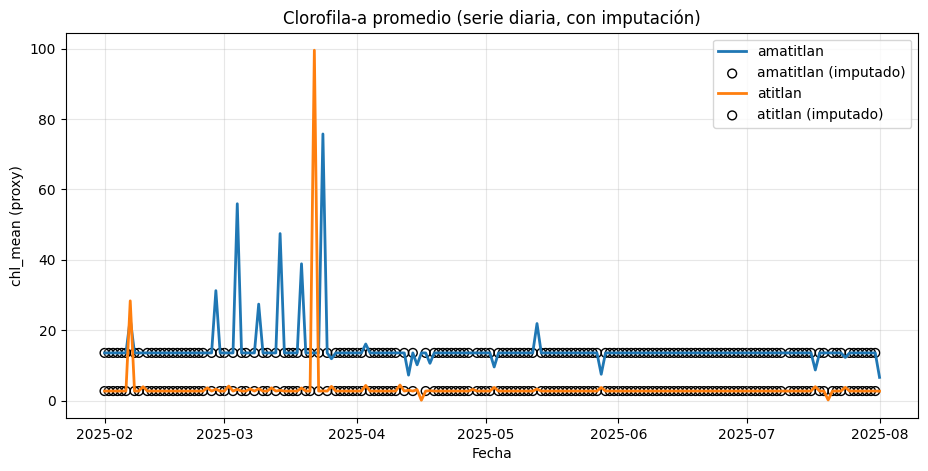

In [32]:
METRICS = ["chl_mean","FAI_mean","NDCI_mean","NDVI_mean","NDWI_mean"]

# Gráfico: clorofila-a promedio por lago
plt.figure(figsize=(11,5))
for lake, g in df_qc.groupby("lake"):
    plt.plot(g["date"], g["chl_mean_clip0"], label=lake, linewidth=2)
    # resalta puntos imputados
    gi = g[g["is_imputed_row"]]
    plt.scatter(gi["date"], gi["chl_mean_clip0"], facecolors="none", edgecolors="black", s=40, label=f"{lake} (imputado)")
plt.title("Clorofila-a promedio (serie diaria, con imputación)")
plt.xlabel("Fecha"); plt.ylabel("chl_mean (proxy)"); plt.grid(True, alpha=0.3); plt.legend()
plt.show()

### Picos de floración y fechas críticas

C:\Users\n8nug\AppData\Local\Temp\ipykernel_7236\3808784939.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_peaks, value_col="chl_mean", window=11, k=3.0, ignore_imputed=True))


amatitlan: 9 picos -> [datetime.date(2025, 2, 7), datetime.date(2025, 2, 27), datetime.date(2025, 3, 4), datetime.date(2025, 3, 9), datetime.date(2025, 3, 14), datetime.date(2025, 3, 19), datetime.date(2025, 3, 24), datetime.date(2025, 4, 3), datetime.date(2025, 5, 13)]
atitlan: 14 picos -> [datetime.date(2025, 2, 7), datetime.date(2025, 2, 10), datetime.date(2025, 2, 25), datetime.date(2025, 2, 27), datetime.date(2025, 3, 4), datetime.date(2025, 3, 9), datetime.date(2025, 3, 19), datetime.date(2025, 3, 22), datetime.date(2025, 3, 26), datetime.date(2025, 4, 3), datetime.date(2025, 5, 3), datetime.date(2025, 5, 13), datetime.date(2025, 5, 28), datetime.date(2025, 7, 17)]


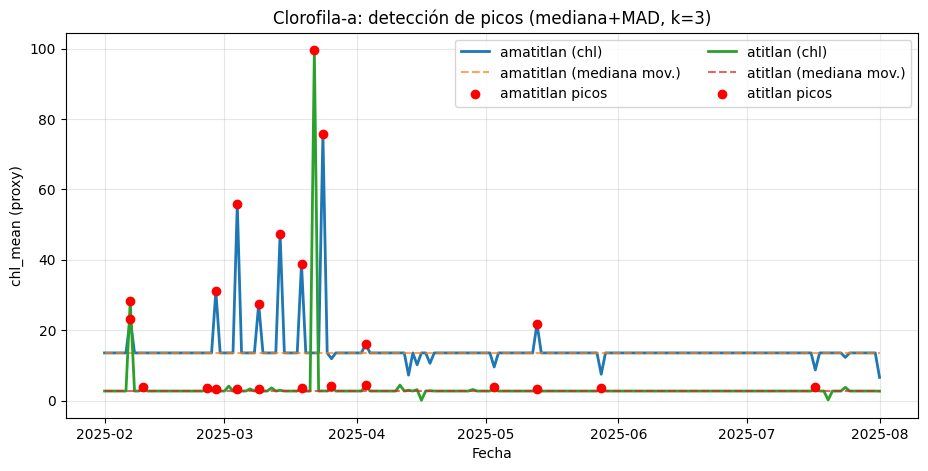

In [33]:
def detect_peaks(group, value_col="chl_mean", window=11, k=3.0, ignore_imputed=True):
    """Devuelve el mismo DataFrame con columnas: rolling_med, mad, z_robusto, is_peak."""
    g = group.sort_values("date").copy()
    x = g[value_col]

    # mediana y MAD (robustos)
    med = x.rolling(window, center=True, min_periods=max(3, window//2)).median()
    mad = (x - med).abs().rolling(window, center=True, min_periods=max(3, window//2)).median()
    zrob = (x - med) / (mad + 1e-6)

    is_peak = zrob > k
    if ignore_imputed and "is_imputed_row" in g.columns:
        is_peak = is_peak & (~g["is_imputed_row"])

    g["rolling_med"] = med
    g["mad"] = mad
    g["z_robusto"] = zrob
    g["is_peak"] = is_peak
    return g

peaks_df = (df_qc.groupby("lake", group_keys=False)
            .apply(detect_peaks, value_col="chl_mean", window=11, k=3.0, ignore_imputed=True))

# Resumen de picos por lago
for lake, g in peaks_df.groupby("lake"):
    dates = g.loc[g["is_peak"], "date"].dt.date.tolist()
    print(f"{lake}: {len(dates)} picos ->", dates)

# Visual anotando picos:
plt.figure(figsize=(11,5))
for lake, g in peaks_df.groupby("lake"):
    plt.plot(g["date"], g["chl_mean_clip0"], label=f"{lake} (chl)", linewidth=2)
    plt.plot(g["date"], g["rolling_med"], linestyle="--", alpha=0.7, label=f"{lake} (mediana mov.)")
    pk = g[g["is_peak"]]
    plt.scatter(pk["date"], pk["chl_mean_clip0"], color="red", zorder=3, label=f"{lake} picos")
plt.title("Clorofila-a: detección de picos (mediana+MAD, k=3)")
plt.xlabel("Fecha"); plt.ylabel("chl_mean (proxy)"); plt.grid(True, alpha=0.3); plt.legend(ncol=2)
plt.show()


### Mapa de la distribución de cianobacteria

In [34]:
import folium
from PIL import Image
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from rasterio.warp import transform_bounds

BASE = Path("descargas_sentinelhub")
OUTF = Path("resultados/maps"); OUTF.mkdir(parents=True, exist_ok=True)


### Guardando los png de los lagos

In [35]:
def _bands_path(lake, date_str):
    return BASE / lake / f"{lake}__{date_str}.bands.tiff"

def _bounds_latlon(bands_path: Path):
    with rasterio.open(bands_path) as src:
        b = src.bounds; crs = src.crs
        if crs and crs.to_string() != "EPSG:4326":
            left, bottom, right, top = transform_bounds(crs, "EPSG:4326", b.left, b.bottom, b.right, b.top)
        else:
            left, bottom, right, top = b.left, b.bottom, b.right, b.top
    return (left, bottom, right, top)

def _save_rgba_png(arr, water_mask, out_png, vmin=None, vmax=None, cmap_name="viridis", alpha=0.85):
    a = np.ma.array(arr, mask=~water_mask)
    if vmin is None or vmax is None:
        vals = a.compressed()
        if vals.size == 0:
            raise ValueError("No hay píxeles de agua válidos para esta fecha.")
        vmin, vmax = np.nanpercentile(vals, [5, 95])

    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    cmap = cm.get_cmap(cmap_name)
    rgba = cmap(norm(a.filled(vmin)))  # RGBA en [0,1]
    rgba[..., 3] = np.where(water_mask, alpha, 0.0)
    Image.fromarray((rgba*255).astype(np.uint8)).save(out_png)
    return vmin, vmax

### Paleta de colores utilizada para identificar la chl

In [36]:
def _mpl_hex_colors(cmap_name="viridis", n=6):
    cmap = cm.get_cmap(cmap_name)
    return [mcolors.to_hex(cmap(x)) for x in np.linspace(0, 1, n)]

In [37]:
def _water_for_map(m):
    w = np.asarray(m["water"], bool)
    if w.sum() == 0 and "NDWI" in m:
        w_alt = np.asarray(m["NDWI"]) > 0
        if w_alt.sum() > 0: return w_alt
    return w

def _png_data_uri(png_path: Path) -> str:
    b = png_path.read_bytes()
    return "data:image/png;base64," + base64.b64encode(b).decode("ascii")

### Función Helper para dibujar los mapas

In [38]:
def ipyl_chl_map(lake, date_str, width=320, height=260, vmin=None, vmax=None, alpha=0.85, show_legend=True):
    mcache = maps_cache[lake][date_str]
    chl = mcache["chl"]; water = _water_for_map(mcache)

    # genera PNG coloreado (usa tu helper existente)
    png_path = OUTF / f"{lake}__{date_str}__chl_ipy.png"
    vmin, vmax = _save_rgba_png(chl, water, png_path, vmin=vmin, vmax=vmax, cmap_name="viridis", alpha=alpha)

    # bounds y centro
    left, bottom, right, top = _bounds_latlon(_bands_path(lake, date_str))
    center = [(bottom+top)/2, (left+right)/2]

    # crea mapa widget con tamaño fijo
    m = Map(center=center, zoom=11, basemap=basemaps.CartoDB.Positron, scroll_wheel_zoom=True)
    m.layout.width  = f"{int(width)}px"
    m.layout.height = f"{int(height)}px"

    # overlay como data URI (sin archivos locales)
    overlay = ImageOverlay(url=_png_data_uri(png_path), bounds=((bottom, left), (top, right)), opacity=1.0)
    m.add(overlay)

    # leyenda opcional
    if show_legend:
        # banda de colores viridis (simple CSS con stops)
        colors = _mpl_hex_colors("viridis", n=8)
        grad = ", ".join([f"{c} {i*100//(len(colors)-1)}%" for i, c in enumerate(colors)])
        legend_html = f"""
        <div style="background:white;padding:6px 8px;border-radius:4px;border:1px solid #ddd;font:12px sans-serif;">
          <div style="margin-bottom:4px;"><b>Clorofila-a (proxy)</b></div>
          <div style="width:160px;height:12px;background:linear-gradient(to right,{grad});border:1px solid #ccc;"></div>
          <div style="display:flex;justify-content:space-between;font:11px sans-serif;">
            <span>{vmin:.1f}</span><span>{vmax:.1f}</span>
          </div>
        </div>
        """
        ctl = WidgetControl(widget=W.HTML(value=legend_html), position="topright")
        m.add_control(ctl)

    return m

### Ejemplo de mapa de Atitlán

In [39]:
ipyl_chl_map("atitlan", "2025-02-07", width=600, height=600)

C:\Users\n8nug\AppData\Local\Temp\ipykernel_7236\1761363087.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
C:\Users\n8nug\AppData\Local\Temp\ipykernel_7236\1231209048.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Map(center=[14.6728895, -91.198883], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

### Ejemplo de mapa de Amatitlán

In [40]:
ipyl_chl_map("amatitlan", "2025-02-07", width=600, height=600)

C:\Users\n8nug\AppData\Local\Temp\ipykernel_7236\1761363087.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
C:\Users\n8nug\AppData\Local\Temp\ipykernel_7236\1231209048.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Map(center=[14.453073, -90.57549449999999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

### Mapas comparativos entre diferentes fechas para cada lago

In [41]:
def compute_subset_scale(lakes, dates, q=(5,95)):
    vals = []
    for lake in lakes:
        for d in dates:
            m = maps_cache.get(lake, {}).get(d)
            if not m: continue
            a = np.ma.array(m["chl"], mask=~_water_for_map(m))
            if a.count(): vals.append(a.compressed())
    allv = np.concatenate(vals) if vals else np.array([0,1])
    vmin, vmax = np.nanpercentile(allv, q)
    return float(vmin), float(vmax)

def compare_dates_grid_ipyl(lakes, dates, width=320, height=260, show_legend_in="top-right"):
    vmin, vmax = compute_subset_scale(lakes, dates, q=(5,95))
    items = []
    first = True
    for lake in lakes:
        for d in dates:
            show_leg = first and (show_legend_in is not None)
            items.append(ipyl_chl_map(lake, d, width=width, height=height, vmin=vmin, vmax=vmax, show_legend=show_leg))
            first = False
    grid = GridBox(items, layout=Layout(
        grid_template_columns=f"repeat({len(dates)}, {width}px)",
        grid_gap="8px"
    ))
    return grid

In [42]:
dates = ["2025-02-07", "2025-03-14", "2025-04-03"]
lakes = ["atitlan", "amatitlan"]
compare_dates_grid_ipyl(lakes, dates, width=320, height=260)

C:\Users\n8nug\AppData\Local\Temp\ipykernel_7236\1761363087.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
C:\Users\n8nug\AppData\Local\Temp\ipykernel_7236\1231209048.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


GridBox(children=(Map(center=[14.6728895, -91.198883], controls=(ZoomControl(options=['position', 'zoom_in_tex…